In [37]:
import glob
import os
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [38]:
def find_csv_files(log_dir, algos, filename) -> list[Path]:
    # Matches …/<SEED>/debug/**/finetuning_eval.csv  (depth under debug doesn't matter)
    
    csv_files = dict()
    for algo, env_name, exp_log_dir in algos:
        pattern = os.path.join(log_dir, algo, exp_log_dir, "*", "debug", "**", filename)
        files = [p for p in glob.glob(pattern, recursive=True)]
        if env_name not in csv_files:
            csv_files[env_name] = {algo: files}
        else:
            csv_files[env_name][algo] = files 
    return csv_files


log_dir = "/n/fs/rl-chongyiz/exp_logs/ogbench_logs"
algos = [
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run", "20250510_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_obs_norm=normal_alpha=0.3_ft_size=500000_ft_steps=250000_eval_freq=1000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    ("rebrac_offline2offline", "cheetah_run", "20250510_rebrac_offline2offline_cheetah_run_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=500000_ft_steps=250000_eval_freq=1000_actor_freq=4"),
    
    ("sarsa_ifql_vib_gpi_offline2offline", "cheetah_run_backward", "20250510_sarsa_ifql_vib_gpi_offline2offline_cheetah_run_backward_obs_norm=normal_alpha=0.3_ft_size=500000_ft_steps=250000_eval_freq=1000_num_fg=16_actor_freq=4_expectile=0.9_actor_ln=False_kl_weight=0.05_latent_dim=128"),
    ("rebrac_offline2offline", "cheetah_run_backward", "20250510_rebrac_offline2offline_cheetah_run_backward_obs_norm_type=normal_alpha_actor=0.1_alpha_critic=0.1_ft_size=500000_ft_steps=250000_eval_freq=1000_actor_freq=4"),
    
    
    ("sarsa_ifql_offline2offline", "quadruped_jump", "20250406_sarsa_ifql_offline2offline_quadruped_jump_obs_norm=normal_alpha=3.0_ft_size=500000_ft_steps=250000_eval_freq=2000_num_fg=16_actor_freq=4_expectile=0.75_q_agg=min_critic_fm_loss=sarsa_squared_reward=state_action_bc_pretrain"),
    ("iql_offline2offline", "quadruped_jump", "20250407_iql_offline2offline_quadruped_jump_obs_norm_type=normal_alpha=10.0_ft_size=500000_ft_steps=250000_eval_freq=2000_expectile=0.9_actor_freq=4"),
    ("rebrac_offline2offline", "quadruped_jump", "20250406_rebrac_offline2offline_quadruped_jump_obs_norm_type=normal_alpha_actor=1.0_alpha_critic=1.0_ft_size=500000_ft_steps=250000_eval_freq=2000_actor_freq=4"),

    ("sarsa_ifql_offline2offline", "cube-single-play-singletask-task2-v0", "20250407_sarsa_ifql_offline2offline_cube-single-play-singletask-task2-v0_obs_norm=normal_alpha=30.0_ft_size=500000_ft_steps=250000_eval_freq=2000_num_fg=16_actor_freq=4_expectile=0.8_q_agg=mean_critic_fm_loss=sarsa_squared_reward=state_action_bc_pretrain"),
    ("iql_offline2offline", "cube-single-play-singletask-task2-v0", "20250407_iql_offline2offline_cube-single-play-singletask-task2-v0_obs_norm_type=normal_alpha=1.0_ft_size=500000_ft_steps=250000_eval_freq=2000_expectile=0.9_actor_freq=4"),
    ("rebrac_offline2offline", "cube-single-play-singletask-task2-v0", "20250407_rebrac_offline2offline_cube-single-play-singletask-task2-v0_obs_norm_type=normal_alpha_actor=1.0_alpha_critic=1.0_ft_size=500000_ft_steps=250000_eval_freq=2000_actor_freq=4")
]


env_name_maps = {
    'cheetah_run': 'cheetah run',
    'cheetah_run_backward': 'cheetah run backward',
    'quadruped_jump': 'quadruped jump',
    'walker_walk': 'walker walk',
    'cube-single-play-singletask-task2-v0': 'cube single front',
}
algo_name_maps = {
    'sarsa_ifql_vib_gpi_offline2offline': 'InFOM (Ours)',
    'sarsa_ifql_offline2offline': 'InFOM (Ours)',
    'iql_offline2offline': 'IQL',
    'rebrac_offline2offline': 'ReBRAC',
}


csv_files = find_csv_files(log_dir, algos, filename="finetuning_eval.csv")

In [39]:
def load_data(csv_path, stat_name, step_name) -> np.ndarray:
    df = pd.read_csv(csv_path)
    if stat_name not in df.columns:
        raise KeyError(f"{csv_path} doesn't contain {stat_name}")
    x = df[step_name].values
    y = df[stat_name].values
    return dict(x=x, y=y)


algo_data = defaultdict(dict)
for env_name, env_csv_files in csv_files.items():
    for algo, csv_files in env_csv_files.items():
        seed_data = []
        for csv_file in csv_files:
            if "singletask" in env_name:
                data = load_data(csv_file, "evaluation/episode.success", "step")
            else:
                data = load_data(csv_file, "evaluation/episode.return", "step")
            if len(seed_data) == 0:
                seed_data.append(data["x"])
            else:
                assert np.all(data["x"] == seed_data[0])
            seed_data.append(data["y"])

        seed_data = np.asarray(seed_data)
        # steps = seed_data[0]
        # data = seed_data[1:]
        
        algo_data[env_name_maps[env_name]][algo_name_maps[algo]] = seed_data
        if len(seed_data) == 1:
            print("Warning: only one random seed!")

In [40]:
print(algo_data['cheetah run']['InFOM (Ours)'].shape)
print(algo_data['cheetah run']['ReBRAC'].shape)

print(algo_data['quadruped jump']['InFOM (Ours)'].shape)
print(algo_data['quadruped jump']['IQL'].shape)
print(algo_data['quadruped jump']['ReBRAC'].shape)

print(algo_data['cube single front']['InFOM (Ours)'].shape)
print(algo_data['cube single front']['IQL'].shape)
print(algo_data['cube single front']['ReBRAC'].shape)

(5, 251)
(5, 251)
(3, 126)
(2, 126)
(3, 126)
(2, 126)
(3, 126)
(3, 126)


/u/cz8792/.conda/envs/ogbench/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u/cz8792/.conda/envs/ogbench/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_3435337/3940776205.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


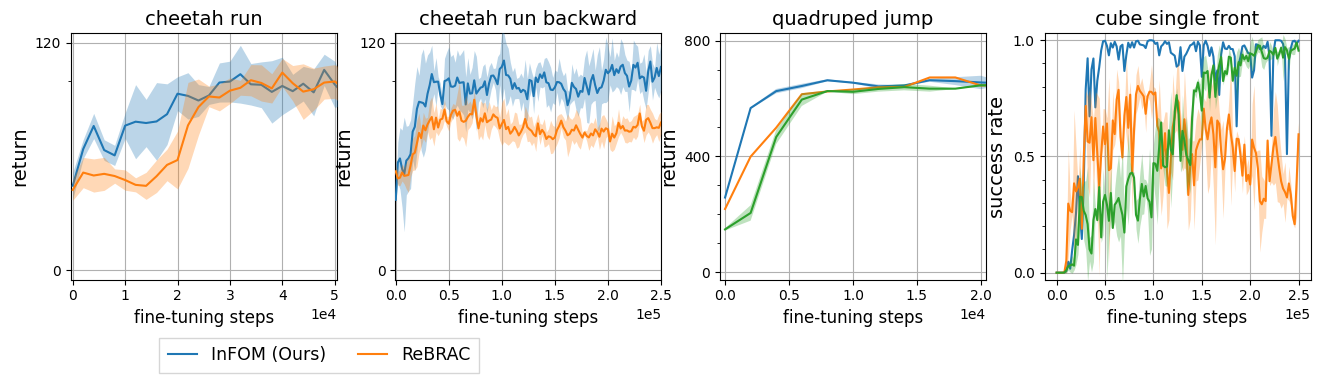

In [62]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 3.2), gridspec_kw=dict(wspace=0.16, hspace=0.5))
fig, axes = plt.subplots(1, 4, figsize=(16., 3.2), gridspec_kw=dict(wspace=0.22, hspace=0.5))

for (env_name, env_data), ax in zip(algo_data.items(), axes):
    for algo, data in env_data.items():
        if ax in [axes[0], axes[1]]:
            x = data[0][::2] - 1e6
            y = data[1:, ::2]
        else:
            x = data[0] - 1e6
            y = data[1:]
        y = gaussian_filter1d(y, 0.5)
        y_mean = np.mean(y, axis=0)
        y_std = np.std(y, axis=0, ddof=1)
        
        l, = ax.plot(x, y_mean, label=algo, zorder=3)
        ax.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.3, lw=0, color=l.get_color(), zorder=3)

    if ax == axes[0]:
        ax.set_ylabel('return', fontsize=14)
        ax.set_xlim([-4e2, 5e4 + 4e2])
        ax.set_ylim([-5, 120 + 5])
        ax.set_yticks([0, 120])
        ax.yaxis.set_minor_locator(MultipleLocator(100))
        
        ax.legend(bbox_to_anchor=(0.3, -0.2),
            loc="upper left", labelspacing=1, columnspacing=1.8075, fancybox=False,
            shadow=False, fontsize=12.5, borderpad=0.5, handlelength=1.7, ncol=3)
    if ax == axes[1]:
        ax.set_ylabel('return', fontsize=14)
        ax.set_xlim([-4e2, 2.5e5 + 4e2])
        ax.set_ylim([-5, 120 + 5])
        ax.set_yticks([0, 120])
        ax.yaxis.set_minor_locator(MultipleLocator(100))
    if ax == axes[2]:
        ax.set_ylabel('return', fontsize=14)
        ax.set_xlim([-4e2, 2e4 + 4e2])
        ax.set_ylim([-25, 825])
        ax.set_yticks([0, 400, 800])
        ax.yaxis.set_minor_locator(MultipleLocator(100))
    elif ax == axes[3]:
        ax.set_ylabel('success rate', fontsize=14)
        ax.set_xlim([-1.25e4, 0.25e6 + 1.25e4])
        ax.set_ylim([-0.03, 1.0 + 0.03])
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    
    ax.set_title(env_name, fontsize=14)
    ax.set_xlabel('fine-tuning steps', fontsize=12)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))  
    
    ax.grid(zorder=3)     

fig.tight_layout()
filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/convergence_speed_ablation_lc.pdf"
fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
